In [1]:
# !pip install torch torchvision opencv-python tqdm scikit-image matplotlib

In [11]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from zipfile import ZipFile
import shutil
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim_metric

# Google Drive setup (Uncomment if saving models to Google Drive)
from google.colab import drive

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!gdown 1JgwTV5N7Lm0MKR5gdMAXLsroNtMff-K5

Downloading...
From (original): https://drive.google.com/uc?id=1JgwTV5N7Lm0MKR5gdMAXLsroNtMff-K5
From (redirected): https://drive.google.com/uc?id=1JgwTV5N7Lm0MKR5gdMAXLsroNtMff-K5&confirm=t&uuid=a41bf043-3b04-4e4c-be3b-d4174cb18e8d
To: /content/preprocessed_data.zip
100% 1.26G/1.26G [00:05<00:00, 222MB/s]


In [14]:
# Unzip the file into the /content directory
!unzip /content/preprocessed_data.zip -d /content/preprocessed_data

Archive:  /content/preprocessed_data.zip
replace /content/preprocessed_data/super_resolution/val/target/5604.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [15]:
# Define local directories for saving images and models
local_base_dir = 'preprocessed_data'  # Directory where data is extracted
model_save_dir_local = '/content/trained_models'  # Local directory to save trained models
os.makedirs(model_save_dir_local, exist_ok=True)

# Define Google Drive destination directory (modify as needed)
drive_model_save_dir = '/content/drive/MyDrive/ImageEnhancement/'
os.makedirs(drive_model_save_dir, exist_ok=True)

# Define tasks
tasks = ['denoising', 'super_resolution', 'colorization', 'inpainting']

# Define PyTorch Dataset and DataLoader


In [16]:
class ImageEnhancementDataset(Dataset):
    def __init__(self, input_dir, target_dir, transform=None):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform = transform
        self.input_images = sorted([f for f in os.listdir(input_dir) if not f.startswith('.')])
        self.target_images = sorted([f for f in os.listdir(target_dir) if not f.startswith('.')])

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        # Read input and target images using OpenCV
        input_img_path = os.path.join(self.input_dir, self.input_images[idx])
        target_img_path = os.path.join(self.target_dir, self.target_images[idx])

        input_img = cv2.imread(input_img_path)
        input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        target_img = cv2.imread(target_img_path)
        target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)

        return input_img, target_img

# Define Transformations

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])


# Create DataLoaders for Each Task

def create_dataloader(task, split, batch_size=16):
    input_dir = os.path.join(local_base_dir, task, split, 'input')
    target_dir = os.path.join(local_base_dir, task, split, 'target')
    dataset = ImageEnhancementDataset(input_dir, target_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    return dataloader

print("Creating DataLoaders for all tasks...")
dataloaders = {}
for task in tasks:
    dataloaders[task] = {}
    dataloaders[task]['train'] = create_dataloader(task, 'train', batch_size=32)
    dataloaders[task]['val'] = create_dataloader(task, 'val', batch_size=32)
print("DataLoaders created successfully.")

Creating DataLoaders for all tasks...
DataLoaders created successfully.


# Model Definition

In [17]:
# Simple U-Net architecture tailored for 32x32 images
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256]):
        super(SimpleUNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        for feature in features:
            self.encoder.append(self.conv_block(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = self.conv_block(features[-1], features[-1]*2)

        # Decoder
        reversed_features = features[::-1]
        decoder_features = features[-1]*2  # Start with bottleneck channels

        for feature in reversed_features:
            self.decoder.append(nn.ConvTranspose2d(decoder_features, feature, kernel_size=2, stride=2))
            self.decoder.append(self.conv_block(decoder_features, feature))
            decoder_features = feature  # Update for next layer

        # Final Convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = nn.functional.interpolate(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx+1](concat_skip)

        return self.final_conv(x)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

# Training and Fine-Tuning

In [9]:
# Define the training (fine-tuning) function
def fine_tune_model(task_name, model, train_loader, val_loader, num_epochs, save_path=None):
    """Fine-tune the given model on the specified task."""
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    print(f"\nStarting fine-tuning for {task_name}...")
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch in tqdm(train_loader, desc=f"{task_name} Epoch {epoch+1}/{num_epochs}"):
            input_imgs, target_imgs = batch
            input_imgs = input_imgs.to(device)
            target_imgs = target_imgs.to(device)

            optimizer.zero_grad()
            outputs = model(input_imgs)
            loss = criterion(outputs, target_imgs)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        print(f"{task_name} Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_imgs, target_imgs = batch
                input_imgs = input_imgs.to(device)
                target_imgs = target_imgs.to(device)

                outputs = model(input_imgs)
                loss = criterion(outputs, target_imgs)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"{task_name} Validation Loss: {avg_val_loss:.4f}")

    # Save the fine-tuned model
    if save_path:
        torch.save(model.state_dict(), save_path)
        print(f"{task_name} model saved to {save_path}")


# Fine-Tune Models for Each Task

In [18]:
def fine_tune_model(task_name, model, train_loader, val_loader, num_epochs, save_path_drive, save_path_local=None):
    """
    Fine-tune the given model on the specified task and save it locally and to Google Drive.

    Args:
        task_name (str): Name of the task.
        model (nn.Module): The U-Net model to fine-tune.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        num_epochs (int): Number of training epochs.
        save_path_drive (str): Path to save the model on Google Drive.
        save_path_local (str, optional): Path to save the model locally. Defaults to None.
    """
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    print(f"\nStarting fine-tuning for {task_name}...")
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch in tqdm(train_loader, desc=f"{task_name} Epoch {epoch+1}/{num_epochs}"):
            input_imgs, target_imgs = batch
            input_imgs = input_imgs.to(device)
            target_imgs = target_imgs.to(device)

            optimizer.zero_grad()
            outputs = model(input_imgs)
            loss = criterion(outputs, target_imgs)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        print(f"{task_name.capitalize()} Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_imgs, target_imgs = batch
                input_imgs = input_imgs.to(device)
                target_imgs = target_imgs.to(device)

                outputs = model(input_imgs)
                loss = criterion(outputs, target_imgs)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"{task_name.capitalize()} Validation Loss: {avg_val_loss:.4f}")

    # Save the fine-tuned model locally
    if save_path_local:
        torch.save(model.state_dict(), save_path_local)
        print(f"{task_name.capitalize()} model saved locally to {save_path_local}")

    # Save the fine-tuned model to Google Drive
    if save_path_drive:
        torch.save(model.state_dict(), save_path_drive)
        print(f"{task_name.capitalize()} model saved to Google Drive at {save_path_drive}")


In [19]:
print("Fine-Tuning Models for Each Task")

for task in tasks:
    print(f"\n--- Fine-Tuning {task.capitalize()} Model ---")
    model = SimpleUNet().to(device)

    # Define local and Drive save paths
    save_path_local = os.path.join(model_save_dir_local, f'{task}_model.pth')
    save_path_drive = os.path.join(drive_model_save_dir, f'{task}_model.pth')

    # Fine-tune the model
    fine_tune_model(
        task_name=task,
        model=model,
        train_loader=dataloaders[task]['train'],
        val_loader=dataloaders[task]['val'],
        num_epochs=25,  # Adjust as needed
        save_path_drive=save_path_drive,
        save_path_local=save_path_local
    )

print("Model Fine-Tuning Completed Successfully!")

Fine-Tuning Models for Each Task

--- Fine-Tuning Denoising Model ---

Starting fine-tuning for denoising...


denoising Epoch 1/25: 100%|██████████| 1500/1500 [00:18<00:00, 80.08it/s]

Denoising Epoch [1/25], Loss: 0.0082


Denoising Validation Loss: 0.0026


denoising Epoch 2/25: 100%|██████████| 1500/1500 [00:16<00:00, 93.26it/s]

Denoising Epoch [2/25], Loss: 0.0030


Denoising Validation Loss: 0.0025


denoising Epoch 3/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.86it/s]

Denoising Epoch [3/25], Loss: 0.0026


Denoising Validation Loss: 0.0022


denoising Epoch 4/25: 100%|██████████| 1500/1500 [00:16<00:00, 93.32it/s]

Denoising Epoch [4/25], Loss: 0.0023


Denoising Validation Loss: 0.0019


denoising Epoch 5/25: 100%|██████████| 1500/1500 [00:16<00:00, 92.33it/s]

Denoising Epoch [5/25], Loss: 0.0022


Denoising Validation Loss: 0.0018


denoising Epoch 6/25: 100%|██████████| 1500/1500 [00:16<00:00, 92.91it/s]

Denoising Epoch [6/25], Loss: 0.0020


Denoising Validation Loss: 0.0018


denoising Epoch 7/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.64it/s]

Denoising Epoch [7/25], Loss: 0.0019


Denoising Validation Loss: 0.0018


denoising Epoch 8/25: 100%|██████████| 1500/1500 [00:16<00:00, 92.86it/s]

Denoising Epoch [8/25], Loss: 0.0019


Denoising Validation Loss: 0.0017


denoising Epoch 9/25: 100%|██████████| 1500/1500 [00:16<00:00, 90.88it/s]

Denoising Epoch [9/25], Loss: 0.0018


Denoising Validation Loss: 0.0016


denoising Epoch 10/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.14it/s]

Denoising Epoch [10/25], Loss: 0.0018


Denoising Validation Loss: 0.0016


denoising Epoch 11/25: 100%|██████████| 1500/1500 [00:16<00:00, 90.95it/s]

Denoising Epoch [11/25], Loss: 0.0017


Denoising Validation Loss: 0.0016


denoising Epoch 12/25: 100%|██████████| 1500/1500 [00:16<00:00, 92.38it/s]

Denoising Epoch [12/25], Loss: 0.0017


Denoising Validation Loss: 0.0016


denoising Epoch 13/25: 100%|██████████| 1500/1500 [00:16<00:00, 90.52it/s]

Denoising Epoch [13/25], Loss: 0.0017


Denoising Validation Loss: 0.0017


denoising Epoch 14/25: 100%|██████████| 1500/1500 [00:16<00:00, 89.57it/s]

Denoising Epoch [14/25], Loss: 0.0017


Denoising Validation Loss: 0.0018


denoising Epoch 15/25: 100%|██████████| 1500/1500 [00:16<00:00, 90.98it/s]

Denoising Epoch [15/25], Loss: 0.0016


Denoising Validation Loss: 0.0017


denoising Epoch 16/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.05it/s]

Denoising Epoch [16/25], Loss: 0.0016


Denoising Validation Loss: 0.0015


denoising Epoch 17/25: 100%|██████████| 1500/1500 [00:16<00:00, 90.44it/s]

Denoising Epoch [17/25], Loss: 0.0016


Denoising Validation Loss: 0.0017


denoising Epoch 18/25: 100%|██████████| 1500/1500 [00:16<00:00, 88.74it/s]

Denoising Epoch [18/25], Loss: 0.0016


Denoising Validation Loss: 0.0015


denoising Epoch 19/25: 100%|██████████| 1500/1500 [00:16<00:00, 92.54it/s]

Denoising Epoch [19/25], Loss: 0.0016


Denoising Validation Loss: 0.0016


denoising Epoch 20/25: 100%|██████████| 1500/1500 [00:16<00:00, 90.19it/s]

Denoising Epoch [20/25], Loss: 0.0016


Denoising Validation Loss: 0.0016


denoising Epoch 21/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.79it/s]

Denoising Epoch [21/25], Loss: 0.0016


Denoising Validation Loss: 0.0015


denoising Epoch 22/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.72it/s]

Denoising Epoch [22/25], Loss: 0.0016


Denoising Validation Loss: 0.0015


denoising Epoch 23/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.53it/s]

Denoising Epoch [23/25], Loss: 0.0015


Denoising Validation Loss: 0.0015


denoising Epoch 24/25: 100%|██████████| 1500/1500 [00:16<00:00, 92.00it/s]

Denoising Epoch [24/25], Loss: 0.0015


Denoising Validation Loss: 0.0015


denoising Epoch 25/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.08it/s]

Denoising Epoch [25/25], Loss: 0.0015


Denoising Validation Loss: 0.0016
Denoising model saved locally to /content/trained_models/denoising_model.pth
Denoising model saved to Google Drive at /content/drive/MyDrive/ImageEnhancement/denoising_model.pth

--- Fine-Tuning Super_resolution Model ---

Starting fine-tuning for super_resolution...


super_resolution Epoch 1/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.60it/s]

Super_resolution Epoch [1/25], Loss: 0.0132


Super_resolution Validation Loss: 0.0129


super_resolution Epoch 2/25: 100%|██████████| 1500/1500 [00:16<00:00, 89.88it/s]

Super_resolution Epoch [2/25], Loss: 0.0041


Super_resolution Validation Loss: 0.0028


super_resolution Epoch 3/25: 100%|██████████| 1500/1500 [00:16<00:00, 92.34it/s]

Super_resolution Epoch [3/25], Loss: 0.0035


Super_resolution Validation Loss: 0.0027


super_resolution Epoch 4/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.48it/s]

Super_resolution Epoch [4/25], Loss: 0.0031


Super_resolution Validation Loss: 0.0025


super_resolution Epoch 5/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.52it/s]

Super_resolution Epoch [5/25], Loss: 0.0029


Super_resolution Validation Loss: 0.0024


super_resolution Epoch 6/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.70it/s]

Super_resolution Epoch [6/25], Loss: 0.0027


Super_resolution Validation Loss: 0.0023


super_resolution Epoch 7/25: 100%|██████████| 1500/1500 [00:16<00:00, 92.94it/s]

Super_resolution Epoch [7/25], Loss: 0.0025


Super_resolution Validation Loss: 0.0023


super_resolution Epoch 8/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.18it/s]

Super_resolution Epoch [8/25], Loss: 0.0024


Super_resolution Validation Loss: 0.0023


super_resolution Epoch 9/25: 100%|██████████| 1500/1500 [00:16<00:00, 92.31it/s]

Super_resolution Epoch [9/25], Loss: 0.0023


Super_resolution Validation Loss: 0.0022


super_resolution Epoch 10/25: 100%|██████████| 1500/1500 [00:16<00:00, 90.14it/s]

Super_resolution Epoch [10/25], Loss: 0.0023


Super_resolution Validation Loss: 0.0022


super_resolution Epoch 11/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.04it/s]

Super_resolution Epoch [11/25], Loss: 0.0022


Super_resolution Validation Loss: 0.0021


super_resolution Epoch 12/25: 100%|██████████| 1500/1500 [00:16<00:00, 90.19it/s]

Super_resolution Epoch [12/25], Loss: 0.0022


Super_resolution Validation Loss: 0.0021


super_resolution Epoch 13/25: 100%|██████████| 1500/1500 [00:16<00:00, 90.78it/s]

Super_resolution Epoch [13/25], Loss: 0.0021


Super_resolution Validation Loss: 0.0020


super_resolution Epoch 14/25: 100%|██████████| 1500/1500 [00:16<00:00, 92.51it/s]

Super_resolution Epoch [14/25], Loss: 0.0021


Super_resolution Validation Loss: 0.0020


super_resolution Epoch 15/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.34it/s]

Super_resolution Epoch [15/25], Loss: 0.0021


Super_resolution Validation Loss: 0.0020


super_resolution Epoch 16/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.69it/s]

Super_resolution Epoch [16/25], Loss: 0.0021


Super_resolution Validation Loss: 0.0020


super_resolution Epoch 17/25: 100%|██████████| 1500/1500 [00:16<00:00, 92.03it/s]

Super_resolution Epoch [17/25], Loss: 0.0020


Super_resolution Validation Loss: 0.0020


super_resolution Epoch 18/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.78it/s]

Super_resolution Epoch [18/25], Loss: 0.0020


Super_resolution Validation Loss: 0.0020


super_resolution Epoch 19/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.61it/s]

Super_resolution Epoch [19/25], Loss: 0.0020


Super_resolution Validation Loss: 0.0020


super_resolution Epoch 20/25: 100%|██████████| 1500/1500 [00:16<00:00, 92.36it/s]

Super_resolution Epoch [20/25], Loss: 0.0020


Super_resolution Validation Loss: 0.0020


super_resolution Epoch 21/25: 100%|██████████| 1500/1500 [00:16<00:00, 92.18it/s]

Super_resolution Epoch [21/25], Loss: 0.0019


Super_resolution Validation Loss: 0.0020


super_resolution Epoch 22/25: 100%|██████████| 1500/1500 [00:16<00:00, 90.77it/s]

Super_resolution Epoch [22/25], Loss: 0.0019


Super_resolution Validation Loss: 0.0020


super_resolution Epoch 23/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.47it/s]

Super_resolution Epoch [23/25], Loss: 0.0019


Super_resolution Validation Loss: 0.0020


super_resolution Epoch 24/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.17it/s]

Super_resolution Epoch [24/25], Loss: 0.0019


Super_resolution Validation Loss: 0.0020


super_resolution Epoch 25/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.87it/s]

Super_resolution Epoch [25/25], Loss: 0.0018


Super_resolution Validation Loss: 0.0022
Super_resolution model saved locally to /content/trained_models/super_resolution_model.pth
Super_resolution model saved to Google Drive at /content/drive/MyDrive/ImageEnhancement/super_resolution_model.pth

--- Fine-Tuning Colorization Model ---

Starting fine-tuning for colorization...


colorization Epoch 1/25: 100%|██████████| 1500/1500 [00:16<00:00, 89.81it/s]

Colorization Epoch [1/25], Loss: 0.0137


Colorization Validation Loss: 0.0095


colorization Epoch 2/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.33it/s]

Colorization Epoch [2/25], Loss: 0.0094


Colorization Validation Loss: 0.0086


colorization Epoch 3/25: 100%|██████████| 1500/1500 [00:17<00:00, 84.04it/s]

Colorization Epoch [3/25], Loss: 0.0089


Colorization Validation Loss: 0.0084


colorization Epoch 4/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.03it/s]

Colorization Epoch [4/25], Loss: 0.0085


Colorization Validation Loss: 0.0081


colorization Epoch 5/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.17it/s]

Colorization Epoch [5/25], Loss: 0.0082


Colorization Validation Loss: 0.0081


colorization Epoch 6/25: 100%|██████████| 1500/1500 [00:16<00:00, 89.81it/s]

Colorization Epoch [6/25], Loss: 0.0080


Colorization Validation Loss: 0.0079


colorization Epoch 7/25: 100%|██████████| 1500/1500 [00:16<00:00, 92.20it/s]

Colorization Epoch [7/25], Loss: 0.0077


Colorization Validation Loss: 0.0080


colorization Epoch 8/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.50it/s]

Colorization Epoch [8/25], Loss: 0.0074


Colorization Validation Loss: 0.0077


colorization Epoch 9/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.21it/s]

Colorization Epoch [9/25], Loss: 0.0071


Colorization Validation Loss: 0.0078


colorization Epoch 10/25: 100%|██████████| 1500/1500 [00:16<00:00, 89.05it/s]

Colorization Epoch [10/25], Loss: 0.0067


Colorization Validation Loss: 0.0079


colorization Epoch 11/25: 100%|██████████| 1500/1500 [00:16<00:00, 89.41it/s]

Colorization Epoch [11/25], Loss: 0.0062


Colorization Validation Loss: 0.0080


colorization Epoch 12/25: 100%|██████████| 1500/1500 [00:16<00:00, 90.25it/s]

Colorization Epoch [12/25], Loss: 0.0058


Colorization Validation Loss: 0.0079


colorization Epoch 13/25: 100%|██████████| 1500/1500 [00:16<00:00, 88.37it/s]

Colorization Epoch [13/25], Loss: 0.0055


Colorization Validation Loss: 0.0079


colorization Epoch 14/25: 100%|██████████| 1500/1500 [00:16<00:00, 90.01it/s]

Colorization Epoch [14/25], Loss: 0.0051


Colorization Validation Loss: 0.0079


colorization Epoch 15/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.06it/s]

Colorization Epoch [15/25], Loss: 0.0048


Colorization Validation Loss: 0.0080


colorization Epoch 16/25: 100%|██████████| 1500/1500 [00:16<00:00, 92.12it/s]

Colorization Epoch [16/25], Loss: 0.0046


Colorization Validation Loss: 0.0079


colorization Epoch 17/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.20it/s]

Colorization Epoch [17/25], Loss: 0.0043


Colorization Validation Loss: 0.0081


colorization Epoch 18/25: 100%|██████████| 1500/1500 [00:16<00:00, 92.98it/s]

Colorization Epoch [18/25], Loss: 0.0041


Colorization Validation Loss: 0.0079


colorization Epoch 19/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.17it/s]

Colorization Epoch [19/25], Loss: 0.0039


Colorization Validation Loss: 0.0083


colorization Epoch 20/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.70it/s]

Colorization Epoch [20/25], Loss: 0.0038


Colorization Validation Loss: 0.0079


colorization Epoch 21/25: 100%|██████████| 1500/1500 [00:16<00:00, 90.82it/s]

Colorization Epoch [21/25], Loss: 0.0036


Colorization Validation Loss: 0.0082


colorization Epoch 22/25: 100%|██████████| 1500/1500 [00:16<00:00, 90.98it/s]

Colorization Epoch [22/25], Loss: 0.0034


Colorization Validation Loss: 0.0080


colorization Epoch 23/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.30it/s]

Colorization Epoch [23/25], Loss: 0.0033


Colorization Validation Loss: 0.0081


colorization Epoch 24/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.53it/s]

Colorization Epoch [24/25], Loss: 0.0032


Colorization Validation Loss: 0.0083


colorization Epoch 25/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.34it/s]

Colorization Epoch [25/25], Loss: 0.0030


Colorization Validation Loss: 0.0079
Colorization model saved locally to /content/trained_models/colorization_model.pth
Colorization model saved to Google Drive at /content/drive/MyDrive/ImageEnhancement/colorization_model.pth

--- Fine-Tuning Inpainting Model ---

Starting fine-tuning for inpainting...


inpainting Epoch 1/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.13it/s]

Inpainting Epoch [1/25], Loss: 0.0050


Inpainting Validation Loss: 0.0021


inpainting Epoch 2/25: 100%|██████████| 1500/1500 [00:16<00:00, 92.05it/s]

Inpainting Epoch [2/25], Loss: 0.0022


Inpainting Validation Loss: 0.0014


inpainting Epoch 3/25: 100%|██████████| 1500/1500 [00:16<00:00, 90.25it/s]

Inpainting Epoch [3/25], Loss: 0.0017


Inpainting Validation Loss: 0.0012


inpainting Epoch 4/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.79it/s]

Inpainting Epoch [4/25], Loss: 0.0015


Inpainting Validation Loss: 0.0011


inpainting Epoch 5/25: 100%|██████████| 1500/1500 [00:16<00:00, 89.76it/s]

Inpainting Epoch [5/25], Loss: 0.0014


Inpainting Validation Loss: 0.0013


inpainting Epoch 6/25: 100%|██████████| 1500/1500 [00:16<00:00, 92.17it/s]

Inpainting Epoch [6/25], Loss: 0.0013


Inpainting Validation Loss: 0.0010


inpainting Epoch 7/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.73it/s]

Inpainting Epoch [7/25], Loss: 0.0012


Inpainting Validation Loss: 0.0010


inpainting Epoch 8/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.67it/s]

Inpainting Epoch [8/25], Loss: 0.0011


Inpainting Validation Loss: 0.0011


inpainting Epoch 9/25: 100%|██████████| 1500/1500 [00:16<00:00, 90.58it/s]

Inpainting Epoch [9/25], Loss: 0.0011


Inpainting Validation Loss: 0.0010


inpainting Epoch 10/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.70it/s]

Inpainting Epoch [10/25], Loss: 0.0010


Inpainting Validation Loss: 0.0010


inpainting Epoch 11/25: 100%|██████████| 1500/1500 [00:16<00:00, 90.03it/s]

Inpainting Epoch [11/25], Loss: 0.0010


Inpainting Validation Loss: 0.0010


inpainting Epoch 12/25: 100%|██████████| 1500/1500 [00:16<00:00, 90.85it/s]

Inpainting Epoch [12/25], Loss: 0.0009


Inpainting Validation Loss: 0.0010


inpainting Epoch 13/25: 100%|██████████| 1500/1500 [00:16<00:00, 92.62it/s]

Inpainting Epoch [13/25], Loss: 0.0008


Inpainting Validation Loss: 0.0009


inpainting Epoch 14/25: 100%|██████████| 1500/1500 [00:16<00:00, 90.66it/s]

Inpainting Epoch [14/25], Loss: 0.0008


Inpainting Validation Loss: 0.0009


inpainting Epoch 15/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.78it/s]

Inpainting Epoch [15/25], Loss: 0.0008


Inpainting Validation Loss: 0.0009


inpainting Epoch 16/25: 100%|██████████| 1500/1500 [00:16<00:00, 90.56it/s]

Inpainting Epoch [16/25], Loss: 0.0007


Inpainting Validation Loss: 0.0009


inpainting Epoch 17/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.05it/s]

Inpainting Epoch [17/25], Loss: 0.0007


Inpainting Validation Loss: 0.0009


inpainting Epoch 18/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.16it/s]

Inpainting Epoch [18/25], Loss: 0.0007


Inpainting Validation Loss: 0.0009


inpainting Epoch 19/25: 100%|██████████| 1500/1500 [00:16<00:00, 90.67it/s]

Inpainting Epoch [19/25], Loss: 0.0006


Inpainting Validation Loss: 0.0009


inpainting Epoch 20/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.93it/s]

Inpainting Epoch [20/25], Loss: 0.0006


Inpainting Validation Loss: 0.0009


inpainting Epoch 21/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.16it/s]

Inpainting Epoch [21/25], Loss: 0.0006


Inpainting Validation Loss: 0.0009


inpainting Epoch 22/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.35it/s]

Inpainting Epoch [22/25], Loss: 0.0005


Inpainting Validation Loss: 0.0009


inpainting Epoch 23/25: 100%|██████████| 1500/1500 [00:16<00:00, 91.35it/s]

Inpainting Epoch [23/25], Loss: 0.0005


Inpainting Validation Loss: 0.0009


inpainting Epoch 24/25: 100%|██████████| 1500/1500 [00:16<00:00, 92.68it/s]

Inpainting Epoch [24/25], Loss: 0.0005


Inpainting Validation Loss: 0.0009


inpainting Epoch 25/25: 100%|██████████| 1500/1500 [00:16<00:00, 90.79it/s]

Inpainting Epoch [25/25], Loss: 0.0005


Inpainting Validation Loss: 0.0009
Inpainting model saved locally to /content/trained_models/inpainting_model.pth
Inpainting model saved to Google Drive at /content/drive/MyDrive/ImageEnhancement/inpainting_model.pth
Model Fine-Tuning Completed Successfully!


# Compress Local Models into a Zip File

In [20]:
def zip_models(model_dir, zip_path):
    """
    Compress the trained models into a zip file.

    Args:
        model_dir (str): Directory containing the trained models.
        zip_path (str): Path to save the zip file.
    """
    shutil.make_archive(zip_path.replace('.zip', ''), 'zip', model_dir)
    print(f"Trained models compressed into {zip_path}")

# Define the path for the zip file
models_zip_path = '/content/trained_models.zip'

print("Compressing trained models into a zip file...")
zip_models(model_save_dir_local, models_zip_path)

Compressing trained models into a zip file...
Trained models compressed into /content/trained_models.zip


Upload the Zip File to Google Drive

In [21]:
def upload_zip_to_drive(zip_path, drive_destination_dir):
    """
    Upload the compressed zip file to Google Drive.

    Args:
        zip_path (str): Path to the zip file.
        drive_destination_dir (str): Destination directory in Google Drive.
    """

    # Define the destination path in Google Drive
    drive_zip_path = os.path.join(drive_destination_dir, os.path.basename(zip_path))

    # Copy the zip file to Google Drive
    shutil.copy(zip_path, drive_zip_path)
    print(f"Zip file uploaded to Google Drive at: {drive_zip_path}")

# Define Google Drive destination directory
drive_destination_dir_zip = '/content/drive/MyDrive/ImageEnhancement/'
os.makedirs(drive_destination_dir_zip, exist_ok=True)

print("Uploading the zip file to Google Drive...")
upload_zip_to_drive(models_zip_path, drive_destination_dir_zip)

print("All models saved locally and uploaded to Google Drive successfully!")

Uploading the zip file to Google Drive...
Zip file uploaded to Google Drive at: /content/drive/MyDrive/ImageEnhancement/trained_models.zip
All models saved locally and uploaded to Google Drive successfully!


# Inference

In [22]:
def perform_inference(task_name, model, dataloader, num_samples=3):
    """
    Perform inference on sample images and display the results.

    Args:
        task_name (str): Name of the task.
        model (torch.nn.Module): Fine-tuned model.
        dataloader (DataLoader): DataLoader for the task.
        num_samples (int): Number of samples to perform inference on.
    """
    model.eval()
    samples_processed = 0

    with torch.no_grad():
        for batch in dataloader:
            input_imgs, target_imgs = batch
            input_imgs = input_imgs.to(device)
            target_imgs = target_imgs.to(device)

            outputs = model(input_imgs)
            outputs = outputs.cpu().numpy()
            input_imgs = input_imgs.cpu().numpy()
            target_imgs = target_imgs.cpu().numpy()

            for i in range(outputs.shape[0]):
                if samples_processed >= num_samples:
                    return
                pred = np.transpose(outputs[i], (1, 2, 0))
                input_img = np.transpose(input_imgs[i], (1, 2, 0))
                target_img = np.transpose(target_imgs[i], (1, 2, 0))

                # Clip values to [0,1] for display
                pred = np.clip(pred, 0, 1)
                input_img = np.clip(input_img, 0, 1)
                target_img = np.clip(target_img, 0, 1)

                # Plot the images
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(input_img)
                axs[0].set_title('Input')
                axs[0].axis('off')

                axs[1].imshow(pred)
                axs[1].set_title('Output')
                axs[1].axis('off')

                axs[2].imshow(target_img)
                axs[2].set_title('Target')
                axs[2].axis('off')

                plt.show()
                samples_processed += 1

# Load Trained Models for Inference

In [23]:
print("Loading Trained Models for Inference")

loaded_models = {}
for task in tasks:
    model_path = os.path.join(model_save_dir_local, f'{task}_model.pth')
    if os.path.exists(model_path):
        model = SimpleUNet().to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        loaded_models[task] = model
        print(f"{task.capitalize()} model loaded successfully for inference.")
    else:
        print(f"{task.capitalize()} model not found at {model_path}.")

Loading Trained Models for Inference
Denoising model loaded successfully for inference.


<ipython-input-23-20007979be7a>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Super_resolution model loaded successfully for inference.
Colorization model loaded successfully for inference.
Inpainting model loaded successfully for inference.


# Perform Inference on Sample Images


Performing Inference on Sample Images

--- Denoising ---


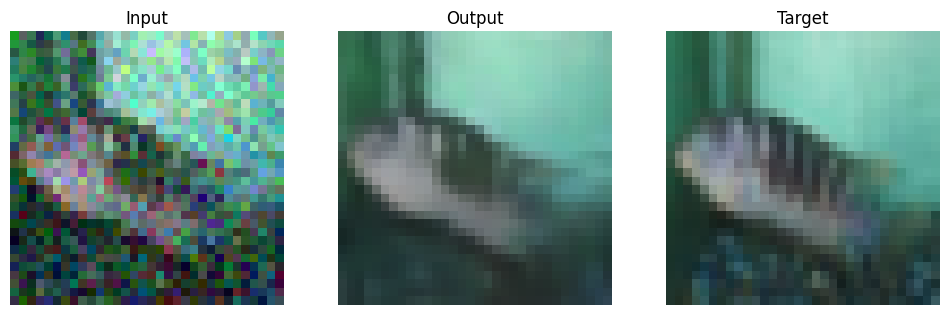

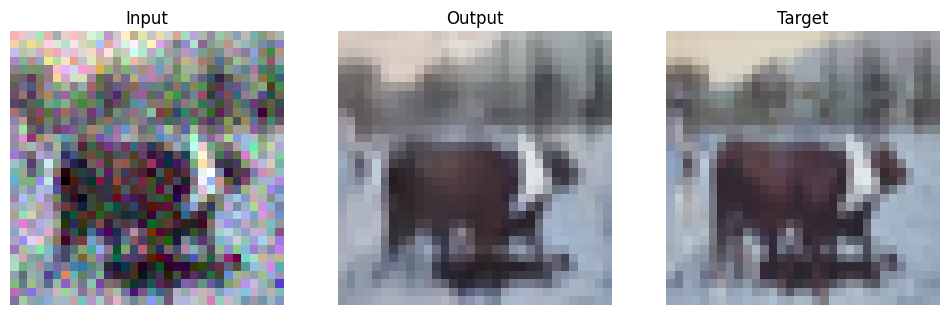

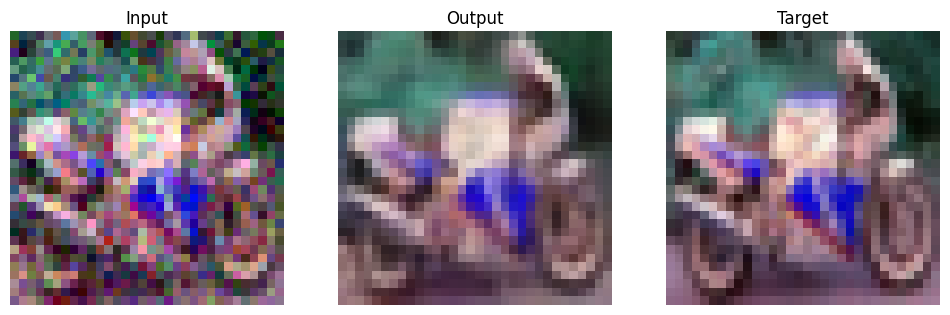


--- Super_resolution ---


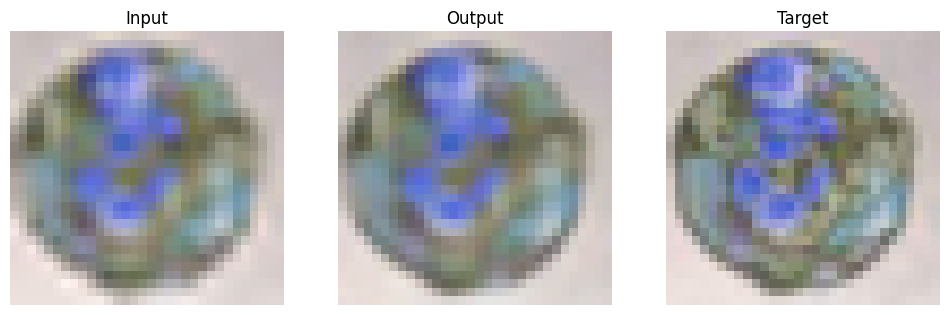

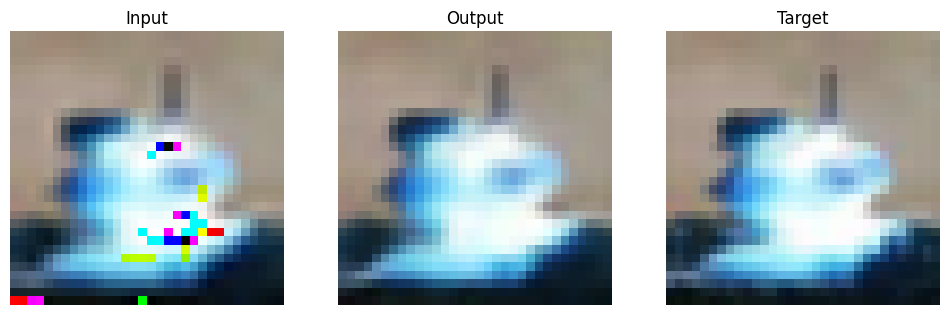

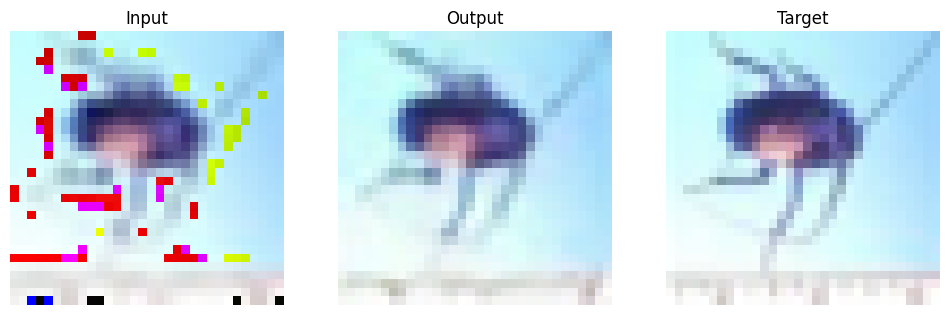


--- Colorization ---


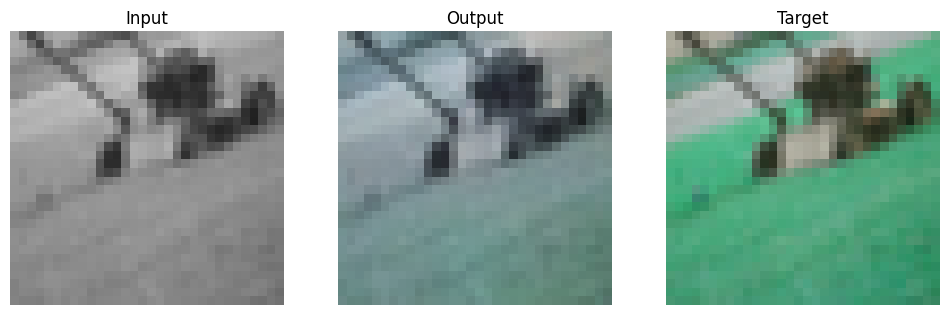

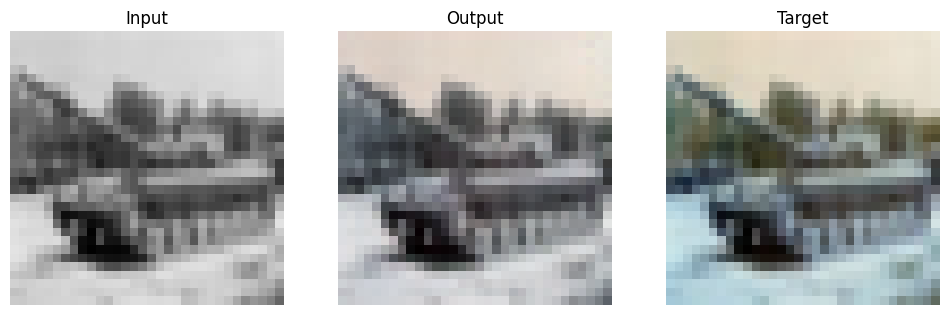

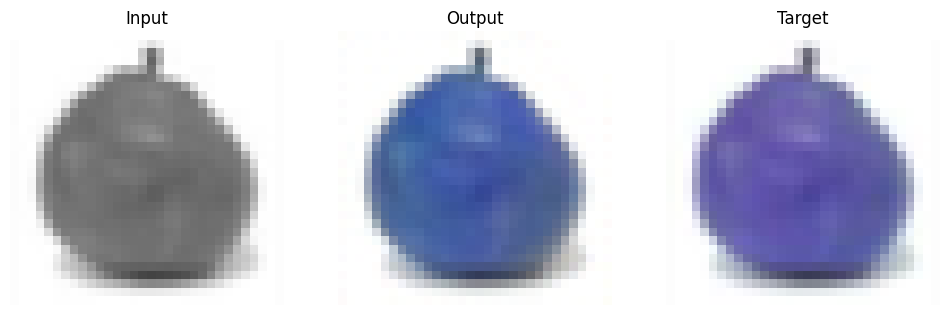


--- Inpainting ---


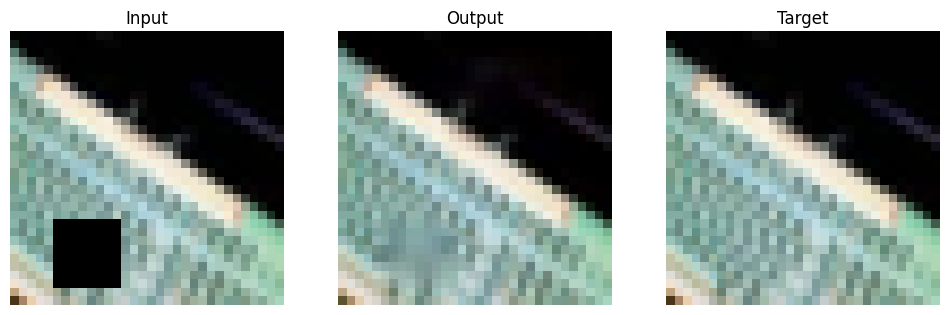

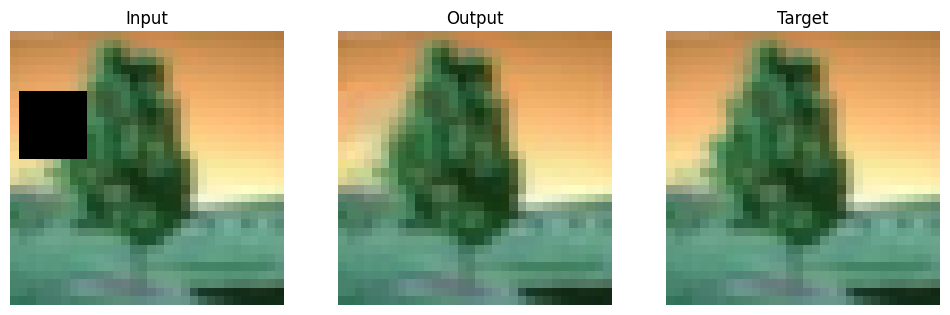

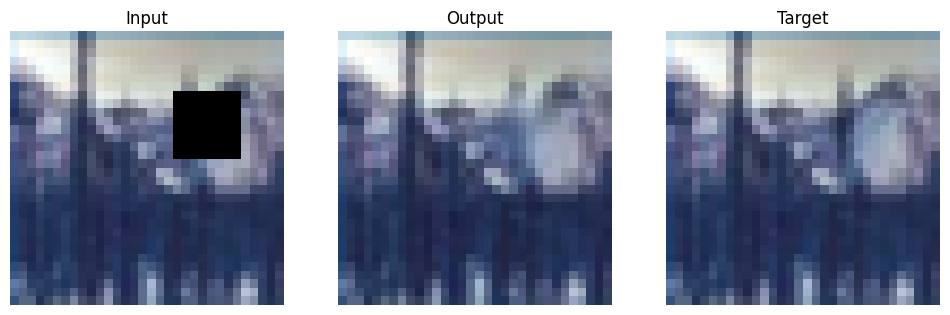


Inference Completed Successfully!


In [24]:
print("Performing Inference on Sample Images")

for task in tasks:
    print(f"\n--- {task.capitalize()} ---")
    try:
        perform_inference(task, loaded_models[task], dataloaders[task]['val'], num_samples=3)
    except Exception as e:
        print(f"Error performing inference for {task}: {e}")

print("\nInference Completed Successfully!")